In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

Reading the dataset

In [4]:
df = pd.read_csv('./datasets/student_admission_record_dirty.csv')

label_column = 'Admission Status'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    147 non-null    object 
 1   Age                     147 non-null    float64
 2   Gender                  147 non-null    object 
 3   Admission Test Score    146 non-null    float64
 4   High School Percentage  146 non-null    float64
 5   City                    147 non-null    object 
 6   Admission Status        147 non-null    object 
dtypes: float64(3), object(4)
memory usage: 8.7+ KB


### Preprocessing

#### Reduction

In [5]:
df.drop(columns=['Name'], inplace=True)

#### Cleaning

In [6]:
df['Admission Test Score'].fillna(df['Admission Test Score'].notna().mean(), inplace=True)
df['High School Percentage'].fillna(df['High School Percentage'].notna().mean(), inplace=True)
df['Age'].fillna(df['Age'].notna().mean(), inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

C:\Users\mogha\AppData\Local\Temp\ipykernel_13096\3056299021.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Admission Test Score'].fillna(df['Admission Test Score'].notna().mean(), inplace=True)
C:\Users\mogha\AppData\Local\Temp\ipykernel_13096\3056299021.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [7]:
df.dropna(subset=['Admission Status'], inplace=True)
df.dropna(subset=['City'], inplace=True)

#### Transformation

In [8]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

In [9]:
encoded_city = pd.get_dummies(df['City'])
df = pd.concat([df, encoded_city], axis=1)
df.drop(columns=['City'], inplace=True)

In [10]:
print(df.shape)
df.head()

(140, 12)


,Age,Gender,Admission Test Score,High School Percentage,Admission Status,Islamabad,Karachi,Lahore,Multan,Peshawar,Quetta,Rawalpindi
0,24.0,0,50.000000,68.900000,Rejected,False,False,False,False,False,True,False
2,17.0,1,89.000000,0.929936,Accepted,True,False,False,False,False,False,False
3,17.0,1,55.000000,85.290000,Rejected,False,True,False,False,False,False,False
5,23.0,0,0.929936,0.929936,Accepted,True,False,False,False,False,False,False
6,18.0,1,0.929936,97.310000,Accepted,False,False,False,True,False,False,False


Keeping the original dataset away; using the one without the label column (just in case of evaluating the model)

In [11]:
clustering_dataset = df.drop(columns=[label_column])

Required class definitions for ease of implementing the algorithm

In [12]:
class Point:
    def __init__(self, obj: pd.Series, visit_label: bool):
        self.is_visited = visit_label
        self.point = obj

In [13]:
generated_ids = []
class Cluster:
    def __init__(self, members):
        if members is None:
            members = []
        self.members = members
        self.id = self.generate_id()
    def generate_id(self):
        id = ''
        possible_characters = '1234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        while id == '' or id in generated_ids:
            for _ in range(0, 20):
                id += random.choice(possible_characters)
        
        generated_ids.append(id)
        return id

Helping methods

In [14]:
def get_euclidean_distance(obj1: pd.Series, obj2: pd.Series):
    result = 0
    for attribute in obj1.keys():
        result += pow(float(obj1[attribute]) - float(obj2[attribute]), 2)

    return math.sqrt(result)

In [15]:
def get_neighbors(center: Point, all_points: list, radius: float) -> list:
    return [p for p in all_points if p is not center and get_euclidean_distance(center.point, p.point) <= radius]

In [16]:
def isin_any_cluster(point: Point, clusters: list)-> bool:
    for cluster in clusters:
        if point in cluster.members:
            return True
    
    return False

Actual DBSCAN implementation

In [17]:
noise_points = []
def perform_dbscan(dataset: pd.DataFrame, epsilon: float, min_points: int) -> list:
    points = [Point(row, False) for _, row in dataset.iterrows()]
    clusters = []
    unvisited_points = points
    while len(unvisited_points) > 0:
        new_visited = random.choice(unvisited_points)
        new_visited.is_visited = True
        neighbors = get_neighbors(new_visited, points, epsilon)
        if len(neighbors) >= min_points: # if newly visited point is a core, form a cluster and iteratively fill it
            new_cluster = Cluster([new_visited])
            for neighbor in neighbors:
                if not neighbor.is_visited:
                    neighbor.is_visited = True
                    new_neighbors = get_neighbors(neighbor, points, epsilon)
                    new_neighbors = [n for n in new_neighbors if n not in neighbors] # to avoid duplication
                    if len(new_neighbors) > min_points:
                        neighbors.extend(new_neighbors)
                if not isin_any_cluster(neighbor, clusters):
                    new_cluster.members.append(neighbor)
            clusters.append(new_cluster)
        else:
            noise_points.append(new_visited) # new visited is noise

        unvisited_points = [p for p in points if p.is_visited == False]

    return clusters

In [18]:
clusters = perform_dbscan(clustering_dataset, epsilon=45, min_points=9)
len(clusters)

2

In [27]:
# random colors for each cluster
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def visualize_clusters_3d(clusters, plotted_features):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in clusters:
        cluster_points = [point.point.values for point in cluster.members]
        cluster_points = list(zip(*cluster_points))  # Transpose to separate x, y, z

        ax.scatter(cluster_points[plotted_features[0]], cluster_points[plotted_features[1]], cluster_points[plotted_features[2]], label=f"Cluster {cluster.id[:8]}", c=random_color())

    ax.set_title("DBSCAN Clusters (3D)")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    plt.legend()
    plt.show()

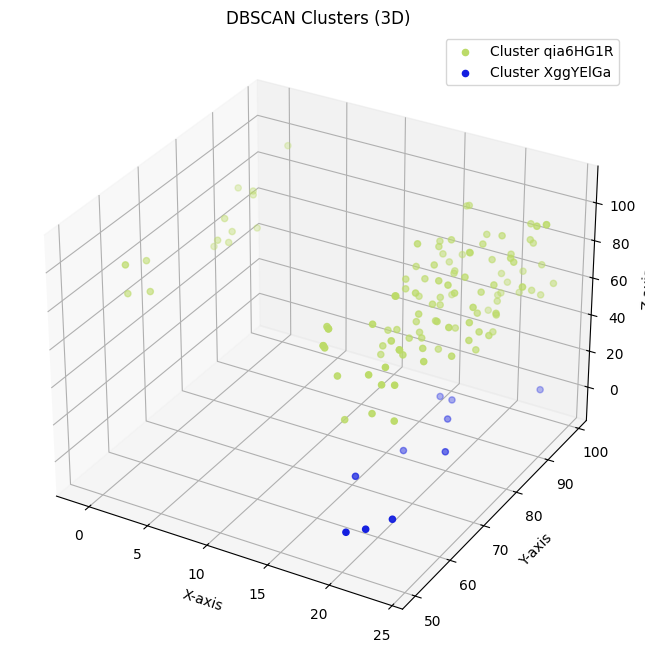

In [32]:
visualize_clusters_3d(clusters, (0, 2, 3))

In [33]:
def get_sse(clusters):
    sse = 0
    for c in clusters:
        points = pd.DataFrame([m.point for m in c.members])
        centroid = points.mean()
        sse += sum([get_euclidean_distance(p, centroid) ** 2 for _, p in points.iterrows()])

    return sse

In [34]:
get_sse(clusters)

58556.33113396294

In [35]:
def get_ssb(clusters):
    ssb = 0
    for c in clusters:
        points = pd.DataFrame([m.point for m in c.members])
        centroid = points.mean()
        ssb += len(c.members) * (get_euclidean_distance(centroid, clustering_dataset.mean())) ** 2

    return ssb 

In [36]:
get_ssb(clusters)

59414.65573242646